<h1 style="color: white; background-color: black; font-weight: bold; text-align: center; border:3px solid black;">CN VS MCInc VS MCIc classification</h1>



In [2]:
import os
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders);

/kaggle/input ['alzheimer-mri-dataset', '3c-dataset', 'alzheimer-s-dataset3c', 'alzheimers-3c-u', 'alzheimers-dataset-4-class-of-images']
/kaggle/input/alzheimer-mri-dataset ['Dataset']
/kaggle/input/alzheimer-mri-dataset/Dataset ['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']
/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented []
/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented []
/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented []
/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented []
/kaggle/input/3c-dataset ['Alzheimer_s Dataset']
/kaggle/input/3c-dataset/Alzheimer_s Dataset ['test', 'train']
/kaggle/input/3c-dataset/Alzheimer_s Dataset/test ['NonDemented', 'VeryMildDemented', 'MildDemented']
/kaggle/input/3c-dataset/Alzheimer_s Dataset/test/NonDemented []
/kaggle/input/3c-dataset/Alzheimer_s Dataset/test/VeryMildDemented []
/kaggle/input/3c-dataset/Alzheimer_s Dataset/test/MildDemented []
/kaggle/input/3c-dataset/A

<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Import Libraries</h1>



In [3]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

2024-05-07 16:09:27.814803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 16:09:27.814937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 16:09:27.947829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Load Images</h1>



In [4]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimer-s-dataset3c/Alzheimer_s Dataset')):
    subfolder_path = os.path.join('/kaggle/input/alzheimer-s-dataset3c/Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 79.85it/s]


,image,label
0,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,NonDemented
1,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,NonDemented
2,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,NonDemented
3,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,NonDemented
4,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,NonDemented
...,...,...
6383,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,MildDemented
6384,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,MildDemented
6385,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,MildDemented
6386,/kaggle/input/alzheimer-s-dataset3c/Alzheimer_...,MildDemented


<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Visualising and Preparing Dataset </h1>



In [5]:
disease_mapping = {
    'Cognitively normal' : 'NC',
    'Early mild cognitive impairment': 'MCInc',
    'Late mild cognitive impairment' : 'MCIc/AD',
}

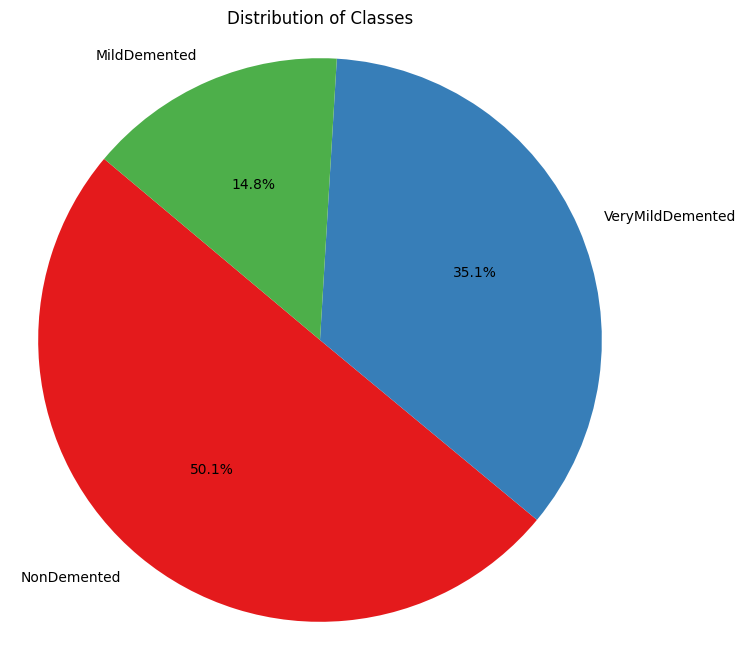

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = df['label'].value_counts().index.tolist()
sizes = df['label'].value_counts().tolist()

plt.figure(figsize=(8, 8));
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set1'))
plt.title('Distribution of Classes')
plt.axis('equal')  
plt.show()


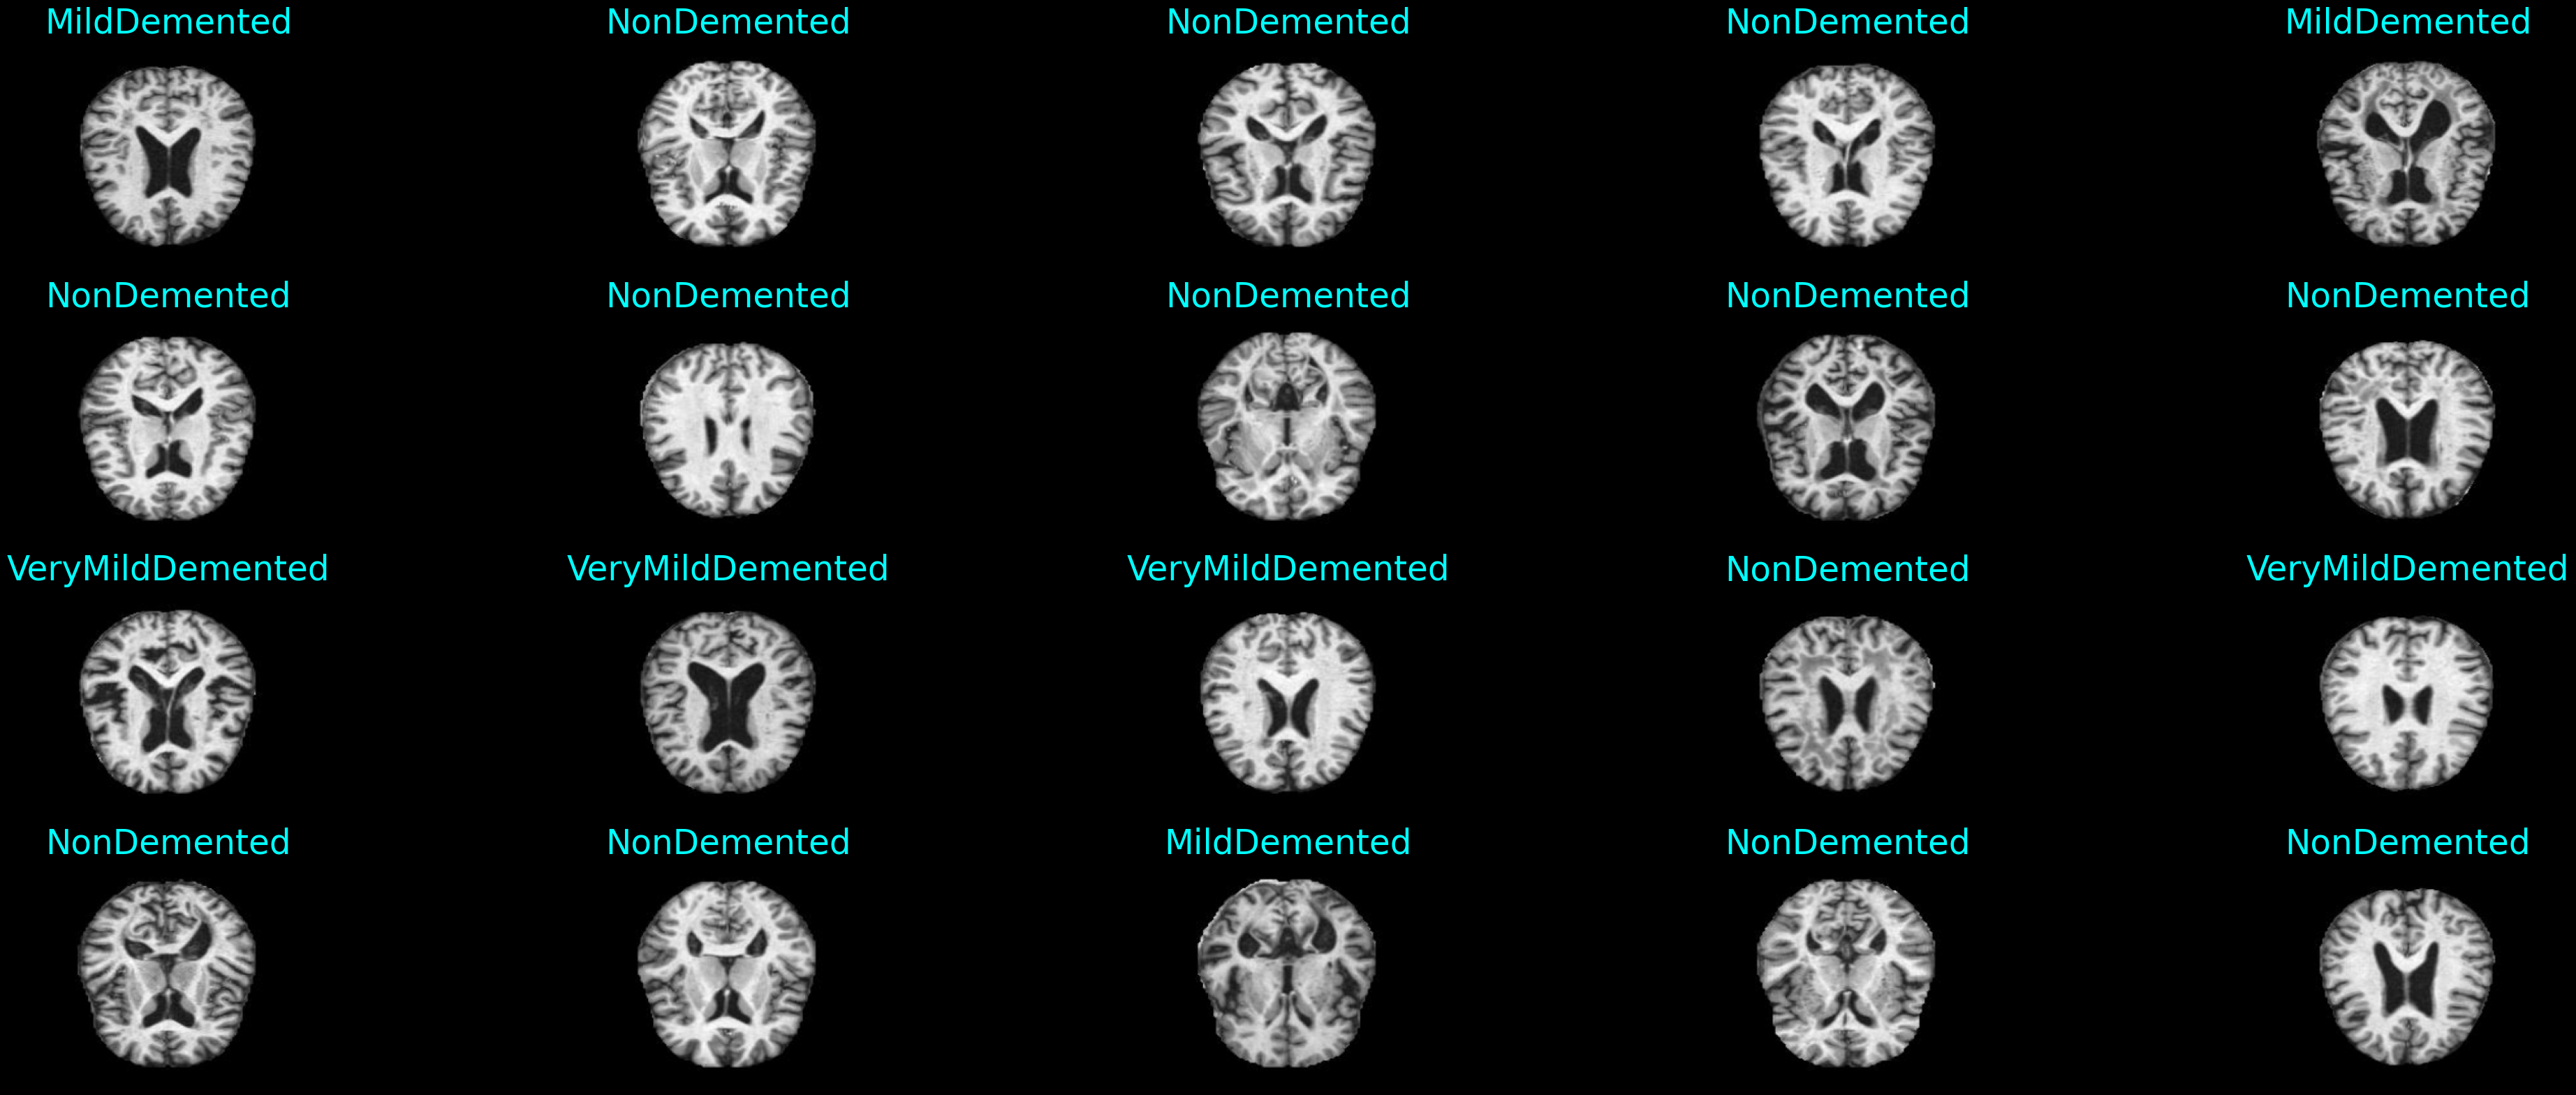

In [7]:
plt.figure(figsize=(50,50), facecolor='black')
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=35,color='aqua')

In [8]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6388 validated image filenames belonging to 3 classes.


In [9]:
train_data, train_labels = next(train_data_gen)


In [10]:
class_num=np.sort(['Cognitively normal','Early mild cognitive impairment','Late mild cognitive impairment'])
class_num

array(['Cognitively normal', 'Early mild cognitive impairment',
       'Late mild cognitive impairment'], dtype='<U31')

<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Applying Class Weights</h1>



In [13]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train is a TensorFlow tensor
y_train = tf.concat(list(map(lambda x: x[1], train_data)), axis=0)
y_train_np = y_train.numpy().flatten()  # Flatten the array
classes = np.unique(y_train_np)
class_weight = compute_class_weight('balanced', classes=classes, y=y_train_np)
class_weights = dict(zip(classes, class_weight))


In [11]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.2, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)


<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Designing the Model</h1>



In [12]:
import tensorflow.keras as keras

model = keras.Sequential()
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Concatenate

def conv_block(x, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)
    return x

def dense_block(x, units, dropout_rate):
    x = Dropout(dropout_rate)(x)
    x = Dense(units, activation='relu')(x)
    return x

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:  # Changed 'val_acc' to 'val_accuracy'
            print("\nReached 99% validation accuracy! Terminating training.")
            self.model.stop_training = True

# Callback instances
my_callback = MyCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Define the first model
IMAGE_SIZE = (176, 176)
input_layer = Input(shape=(*IMAGE_SIZE, 3))

x = Conv2D(16, 3, activation='relu', padding='same')(input_layer)
x = Conv2D(16, 3, activation='relu', padding='same')(x)
x = MaxPool2D()(x)

x = conv_block(x, 32)
x = conv_block(x, 64)
x = conv_block(x, 128)

x = Dropout(0.2)(x)
x = conv_block(x, 256)

x = Dropout(0.2)(x)
x = Flatten()(x)
x = dense_block(x, 512, 0.7)
x = dense_block(x, 128, 0.5)

output_layer1 = Dense(3, activation='softmax', name='output_layer1')(x)

# Define the second model
input_layer2 = Input(shape=(176, 176, 3))
x2 = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(input_layer2)
x2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(x2)
x2 = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x2)
x2 = MaxPool2D((2, 2), 2, padding='same')(x2)
x2 = Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same')(x2)
x2 = MaxPool2D((2, 2), 2, padding='same')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.3)(x2)

output_layer2 = Dense(3, activation='softmax', name='output_layer2')(x2)

# Concatenate the outputs
concatenated_output = Concatenate(name='concatenated_output')([output_layer1, output_layer2])

# Additional dense layer for final output
final_output = Dense(3, activation='softmax', name='final_output')(concatenated_output)

# Merge the two models
merged_model = Model(inputs=[input_layer, input_layer2], outputs=final_output, name="merged_model")
merged_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use callbacks for training
CALLBACKS = [my_callback, early_stopping]

# Convolutional layers
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', input_shape=(176, 176, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

# Flatten layer
model.add(keras.layers.Flatten())

# Fully connected layers
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# Output layer
model.add(keras.layers.Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the architecture of the merged model to an image file
from tensorflow.keras.utils import plot_model
plot_model(merged_model, show_shapes=True, show_layer_names=True, to_file='Merged_Model.png', rankdir='LR')
merged_model.summary()



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "merged_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 176, 176,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 176, 176,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 88, 88,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 88, 88,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 88, 88,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 44, 44,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 44, 44,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 44, 44,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 11, 11,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 11,    │          0 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 11, 11,    │    295,168 │ dropout[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 88, 88,    │        896 │ input_layer_1[0]

 Total params: 5,799,147 (22.12 MB)

 Trainable params: 5,799,147 (22.12 MB)

 Non-trainable params: 0 (0.00 B)

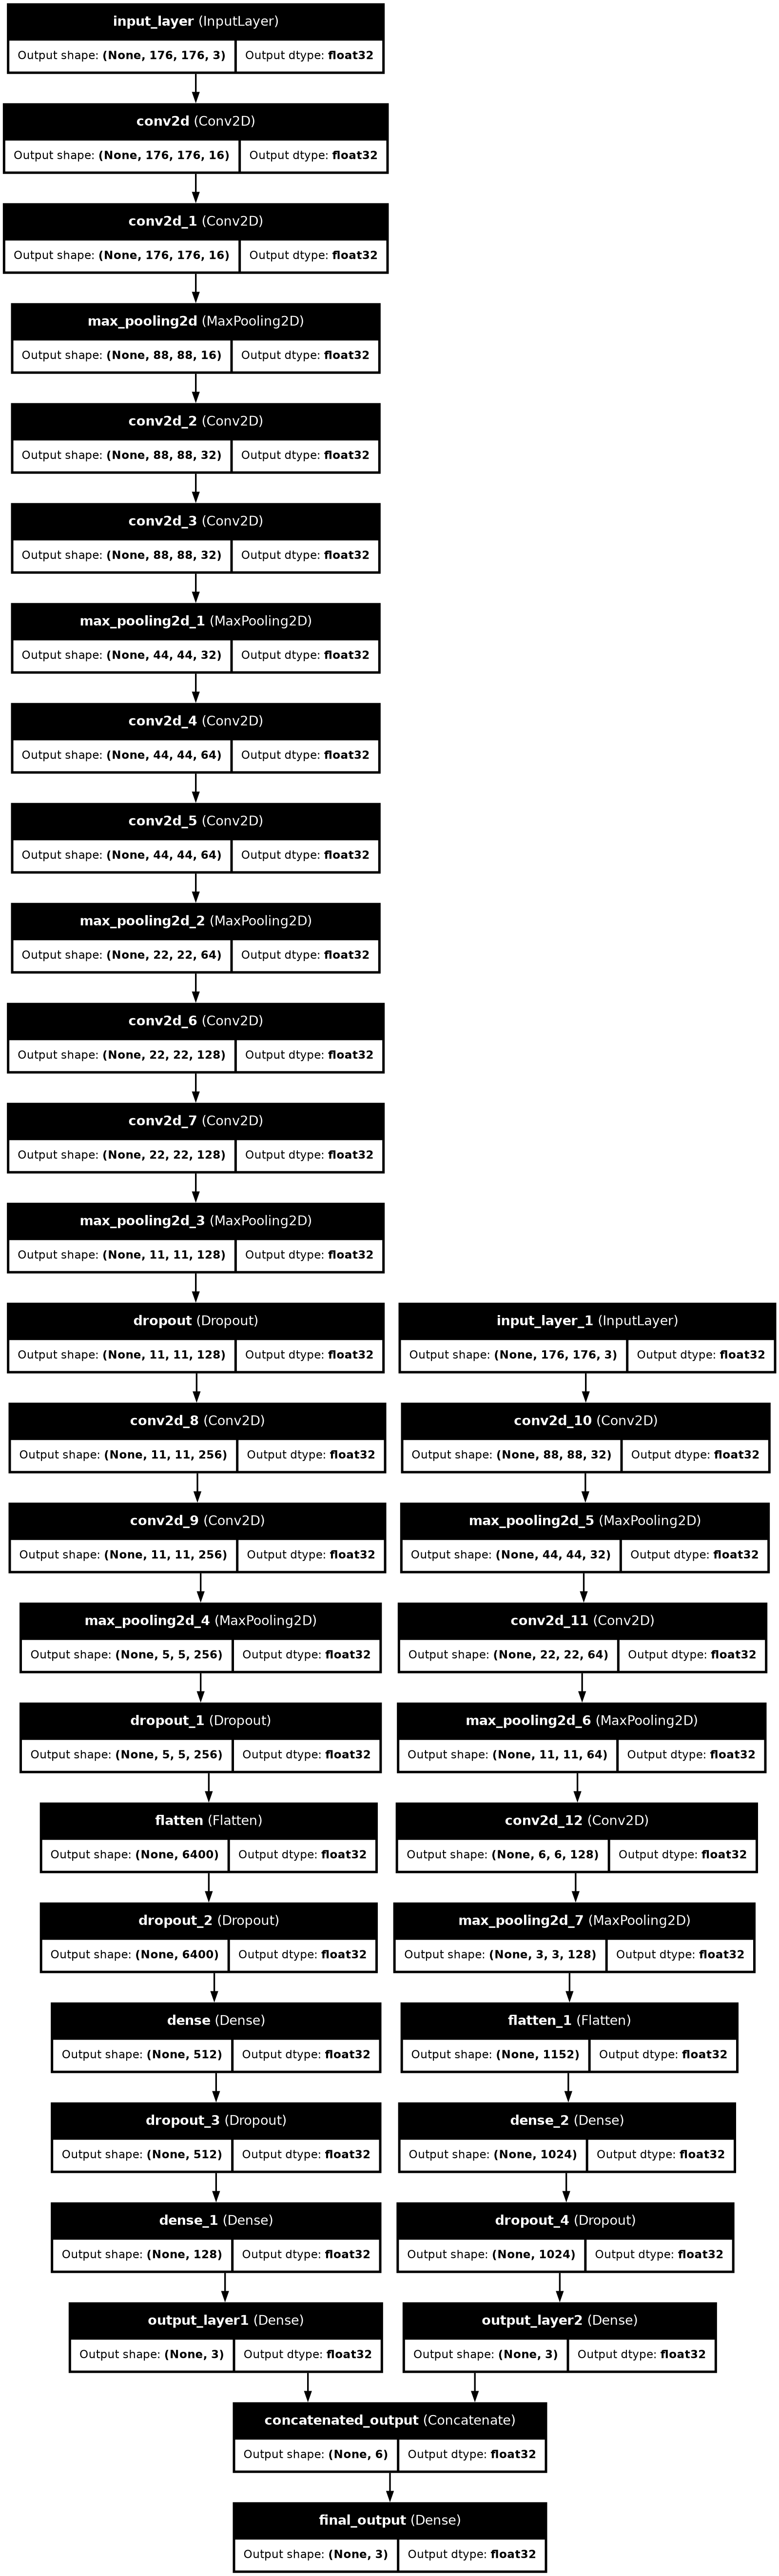

In [10]:
tf.keras.utils.plot_model(merged_model, to_file='Merged_Model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [13]:
checkpoint_cb = ModelCheckpoint("CNN_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb],verbose=0);
model.save("3c-Alzh-Net.h5")

<h1 style="color: white; background-color: gray; font-weight: bold; text-align: center; border:3px solid black;">Evaluating the Model</h1>



In [14]:
hist_=pd.DataFrame(hist.history)


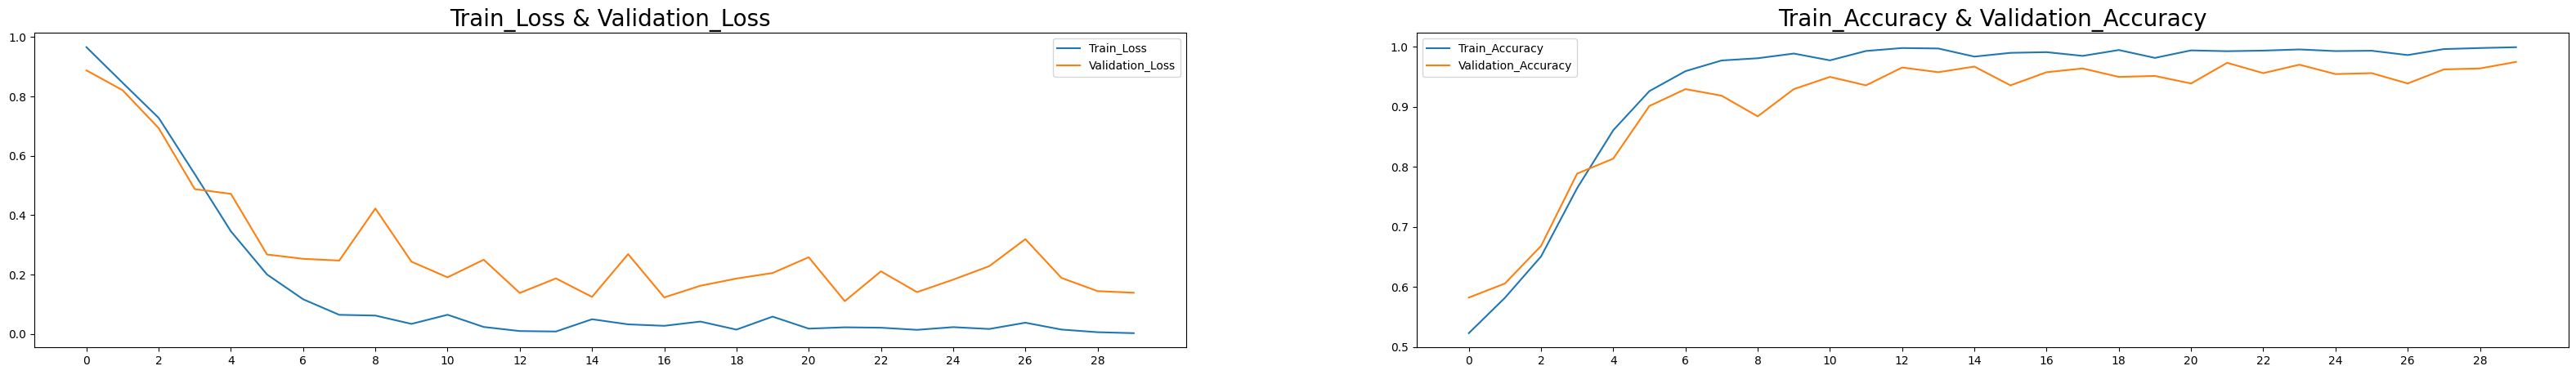

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'][:30], label='Train_Loss')
plt.plot(hist_['val_loss'][:30], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.legend()
plt.xticks(range(0, 30, 2))
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'][:30], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'][:30], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.legend()
plt.xticks(range(0, 30, 2))
plt.show()


In [17]:
score, acc= model.evaluate(X_test,y_test);
print('Test Loss =', score)
print('Test Accuracy =', acc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9770 - loss: 0.1152
Test Loss = 0.12571348249912262
Test Accuracy = 0.9687011241912842


In [19]:
predictions = model.predict(X_test);
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


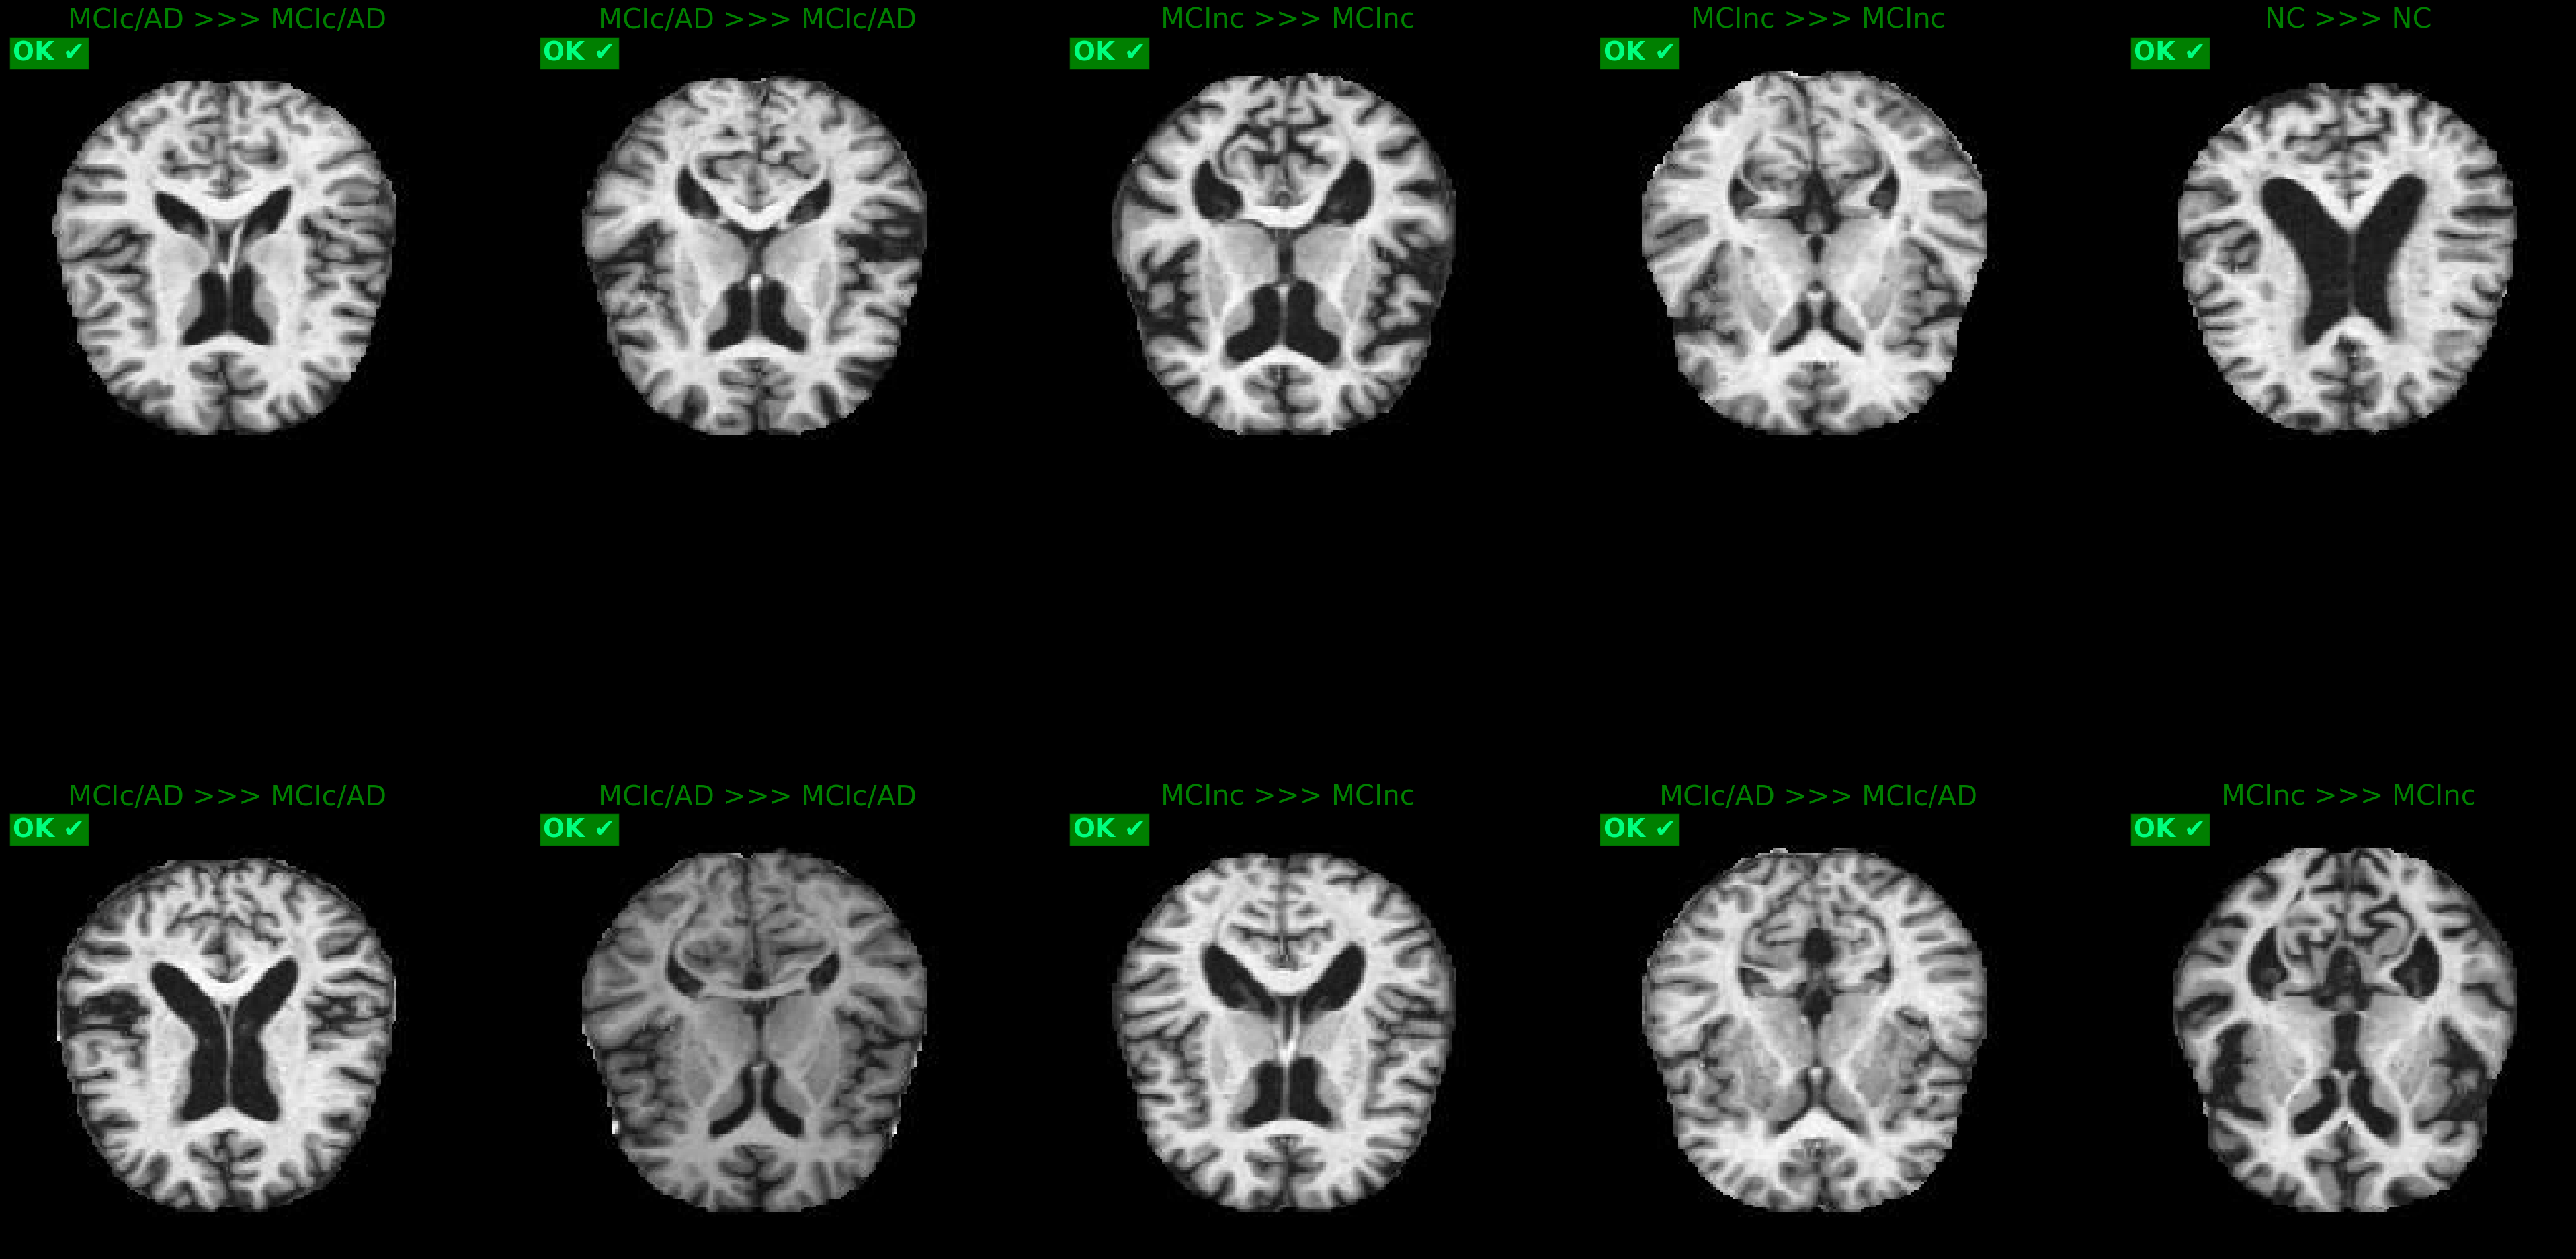

In [20]:
plt.figure(figsize=(50,150), facecolor="Black")
for n,i in enumerate(np.random.randint(0,len(X_test),10)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    
    if (class_num[y_test_[i]]==class_num[y_pred[i]]):
        plt.title(f'{disease_mapping[class_num[y_test_[i]]]} >>> {disease_mapping[class_num[y_pred[i]]]}',fontsize=30,color='green')
        ok_text = plt.text(2, 10, "OK \u2714", color="springgreen", fontsize=28,fontweight="bold")
        ok_text.set_bbox(dict(facecolor='lime', alpha=0.5))
    else:
        plt.title(f'{disease_mapping[class_num[y_test_[i]]]} >>> {disease_mapping[class_num[y_pred[i]]]}',fontsize=30,color='red')
        nok_text = plt.text(2, 10, "NOK \u2718", color="red", fontsize=28)
        nok_text.set_bbox(dict(facecolor='maroon', alpha=0.5))

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f'{class_num[y_test_[i]]} >>> {class_num[y_pred[i]]}',fontsize=15)

array([[141,   0,   1],
       [  3, 395,  20],
       [  4,  19, 313]])

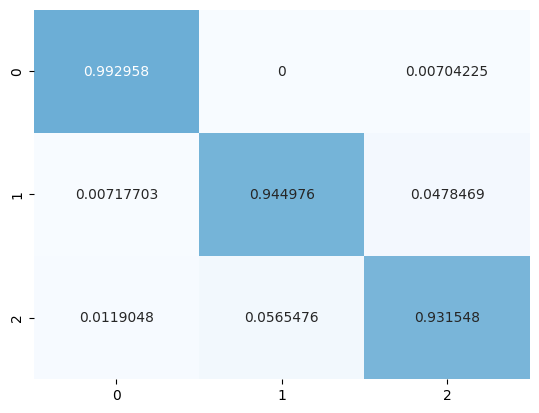

In [19]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [21]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       142
           1       0.96      0.98      0.97       418
           2       0.97      0.94      0.96       336

    accuracy                           0.97       896
   macro avg       0.97      0.97      0.97       896
weighted avg       0.97      0.97      0.97       896

